In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install -q opencv-python scikit-image

In [6]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [7]:
data_path = "/content/drive/MyDrive/it24101838assigment/archive/Garbage_Dataset_Classification/images"

In [8]:
classes = sorted(os.listdir(data_path))
print("Classes found:", classes)


Classes found: ['cardboard']


In [9]:
IMAGE_SIZE = (128, 128)  # resize images
LBP_POINTS = 24
LBP_RADIUS = 3
HIST_BINS = 16  # color histogram bins


In [10]:
def extract_color_histogram(img):
    # Convert to HSV and compute histogram
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, [HIST_BINS]*3, [0,180,0,256,0,256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_lbp_texture(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_features(img):
    color_hist = extract_color_histogram(img)
    texture_hist = extract_lbp_texture(img)
    return np.hstack([color_hist, texture_hist])

In [11]:
X = []
y = []

for idx, label in enumerate(classes):
    folder = os.path.join(data_path, label)
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMAGE_SIZE)
        features = extract_features(img)
        X.append(features)
        y.append(idx)

X = np.array(X)
y = np.array(y)
print("✅ Features extracted. Shape:", X.shape, y.shape)

✅ Features extracted. Shape: (1115, 4122) (1115,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [24]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {accuracy*100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



✅ Test Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00       223

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223

Confusion Matrix:
 [[223]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

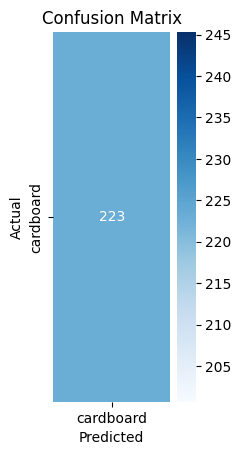

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(1,3,1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [25]:
joblib.dump(rf_model, "/content/drive/MyDrive/random_forest_garbage_features.pkl")
print(" Random Forest model saved to Drive")


 Random Forest model saved to Drive


In [16]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    features = extract_features(img).reshape(1, -1)
    pred_idx = rf_model.predict(features)[0]
    print("Predicted Class:", classes[pred_idx])
